# Bikeshare Modelling

Zach O'Brien

In [1]:
import numpy as np
np.random.seed(9)  # For reproducibility
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import TimeSeriesSplit
import sklearn.linear_model as linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1. Data Preparation

In [2]:
def preprocess_bikeshare_data(df, categorical_cols, label_col):
    """Preprocess the Bikeshare Ridership Data
    
    One-hot encodes categorical columns, and applies MinMaxScaler to the
    label column "cnt" because it will be a feature as well as a label
    in the time series models.
    
    Args:
        df (pd.DataFrame):
            Data
        categorical_cols (list[str]):
            Names of columns to one-hot encode
        label_col (str):
            Name of the label column (column with label)
    
    Returns:
        pd.DataFrame, MinMaxScaler:
            Data with categorical values one-hot encoded and labels scaled,
            and the scaler fit to the original label range
    """
    new_df = one_hot_encode(df, column_names=categorical_cols)
    new_df, scaler = min_max_scale(new_df, col=label_col)
    return new_df, scaler


def one_hot_encode(df, column_names):
    """One-hot encode columns in a DataFrame

    Args:
        df (pd.DataFrame): 
            Data
        column_names (list[str]): 
            Names of columns which should be converted to one-hot encoding

    Returns:
        pd.DataFrame:
            Data with the specified columns converted to one-hot encoding
    """
    df_copy = df.copy()
    dummies = [pd.get_dummies(df_copy[col], prefix=col) for col in column_names]
    df_copy.drop(column_names, axis=1, inplace=True)
    return pd.concat(dummies + [df_copy], axis=1)


def min_max_scale(df, col):
    """Apply MinMax scaling to one column in a DataFrame
    
    Args:
        df (pd.DataFrame):
            Data with a column of real values named `col`
        col (str):
            Name of the column to scale
    
    Returns:
        (pd.Dataframe, MinMaxScaler):
            The Data with `col` scaled, as well as the fit MinMaxScaler so that
            data can be inverse transformed back into the original scale
    """
    scaler = MinMaxScaler()
    label_data = df[col].to_numpy().reshape(-1, 1)
    scaler.fit(label_data)
    df[col] = scaler.transform(label_data)
    return df, scaler

In [3]:
data_file = "data/day.csv"
daily_df = pd.read_csv(data_file)
daily_df.head(3)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349


### Visualization of the daily ridership counts over the span of the dataset

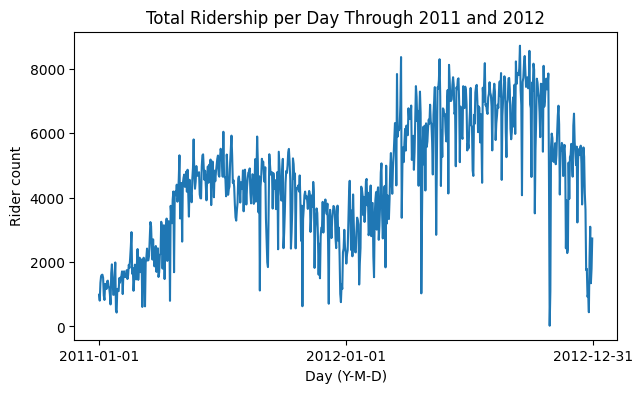

In [4]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(daily_df["cnt"])
ax.set_xlabel("Day (Y-M-D)")
ax.set_ylabel("Rider count")
ax.set_title("Total Ridership per Day Through 2011 and 2012")
ax.set_xticks([0, len(daily_df)//2, len(daily_df)], labels=daily_df["dteday"][[0, len(daily_df)//2, len(daily_df)-1]])
fig.savefig("ridership.jpeg")
plt.show()

In [5]:
# Define which columns we want to keep for model training
categorical_columns = ["season", "holiday", "weekday", "workingday", "weathersit"]
continuous_columns = ["temp", "atemp", "hum", "windspeed"]
feature_columns = categorical_columns + continuous_columns
label_column = "cnt"
# Only keep features and target
daily_df = daily_df[feature_columns + [label_column]]

In [6]:
# Preprocess the data by one-hot encoding the categorical features
# and MinMaxScale-ing the label, because it will also be used as a feature (the previous day's count)
preprocessed_daily_df, daily_label_scaler = preprocess_bikeshare_data(daily_df, categorical_cols=categorical_columns, label_col=label_column)
preprocessed_daily_df.head(3)

,season_1,season_2,season_3,season_4,holiday_0,holiday_1,weekday_0,weekday_1,weekday_2,weekday_3,...,workingday_0,workingday_1,weathersit_1,weathersit_2,weathersit_3,temp,atemp,hum,windspeed,cnt
0,1,0,0,0,1,0,0,0,0,0,...,1,0,0,1,0,0.344167,0.363625,0.805833,0.160446,0.110792
1,1,0,0,0,1,0,1,0,0,0,...,1,0,0,1,0,0.363478,0.353739,0.696087,0.248539,0.089623
2,1,0,0,0,1,0,0,1,0,0,...,0,1,1,0,0,0.196364,0.189405,0.437273,0.248309,0.152669


In [7]:
model_types = ["baseline", "ridge", "feedforward", "lstm"]
BEST_MODEL_PERFORMANCES = {model_type:{"train": 0, "test": 0} for model_type in model_types}

# 2. Non-LSTM Models Training and Evaluation

## 2.1 Create cross validation data for all models **except** LSTM model

The LSTM model will be trained on hourly data instead of daily data to predict the next day's count. So, its data preparation will be a little different.

In [8]:
X = preprocessed_daily_df.iloc[:-1, :].to_numpy()
y = preprocessed_daily_df[[label_column]].iloc[1:, :].to_numpy()

print(f"Inputs have shape: {X.shape}")
print(f"Labels have shape: {y.shape}")

Inputs have shape: (730, 23)
Labels have shape: (730, 1)


In [9]:
def create_timeseries_crossval_splits(data, n_splits):
    """Create train and validation sets for timeseries cross validation
    
    Args:
        data (ndarray): 2D array of input samples
        n_splits (int): Number of subsets for cross validation
    
    Returns:
        list[tuple]: Each tuple is (TRAIN_INDICES, VALIDATION_INDICES)
    """
    timeseries_crossval = TimeSeriesSplit(n_splits=5)
    return list(timeseries_crossval.split(data))

In [10]:
test_set_size = 100  # Last 100 days of data
train_set_size = len(X) - test_set_size

X_train_and_val = X[:train_set_size]
y_train_and_val = y[:train_set_size]
X_test = X[train_set_size:]
y_test = y[train_set_size:]

# Create TRAIN, VALIDATION, and TEST sets for time series cross validation
crossval_indices = create_timeseries_crossval_splits(X_train_and_val, n_splits=5)

print(f"Total dataset size: {len(X)} samples")
print(f"Train and validation set size: {len(X_train_and_val)} samples")
print(f"Holdout test size: {len(X_test)} samples")

Total dataset size: 730 samples
Train and validation set size: 630 samples
Holdout test size: 100 samples


## 2.2 Naive Baseline Model

In [11]:
def baseline_model(input_vectors, cnt_col):
    """A naive model which simply uses the previous day's count
       as the prediction for today"""
    return input_vectors[:, cnt_col]

In [12]:
def get_rmse_baseline_model(model, X, y, scaler, cnt_col):
    baseline_predictions = model(X, cnt_col)
    rmse = np.average(mean_squared_error(y, baseline_predictions, squared=False))
    # The count was MinMaxScaled to use in model training. But for better interpretability of
    # the results, it is transformed back to its original value here
    rmse = scaler.inverse_transform(rmse.reshape(-1, 1))
    return rmse

In [13]:
# The column with the previous day's count is the last item in the vector
RIDERSHIP_COUNT_IDX = X.shape[1] - 1  

baseline_rmse_train = get_rmse_baseline_model(baseline_model, X_train_and_val, y_train_and_val, daily_label_scaler, RIDERSHIP_COUNT_IDX)[0][0]
baseline_rmse_test = get_rmse_baseline_model(baseline_model, X_test, y_test, daily_label_scaler, RIDERSHIP_COUNT_IDX)[0][0]

print(baseline_rmse_train)
print(baseline_rmse_test)

BEST_MODEL_PERFORMANCES["baseline"]["train"] = baseline_rmse_train
BEST_MODEL_PERFORMANCES["baseline"]["test"] = baseline_rmse_test

1035.6402824583395
1363.4416200491169


In [14]:
BEST_MODEL_PERFORMANCES

{'baseline': {'train': 1035.6402824583395, 'test': 1363.4416200491169},
 'ridge': {'train': 0, 'test': 0},
 'feedforward': {'train': 0, 'test': 0},
 'lstm': {'train': 0, 'test': 0}}

## 2.3 Ridge Regression Model

In [15]:
def evaluate_linear_model(model, X, y, ts_crossvalidation_indices):
    """Evaluate a linear model using timeseries cross validation
    
    Args:
        model: A class which can be trained with .fit() and has .predict() to make predictions
        X (ndarray): A 2D array of float values, inputs to the model
        y (ndarray): A 1d array of float values, labels for the inputs
        ts_crossvalidation_indices(list[tuple]): A list of indices for training and testing sets
                                                 to perform timeseries cross validation
    
    Returns:
        list[float], model: RMSE scores for each cross validation subset, and the final trained model
    """
    rmse_scores = []
    for train_indices, validation_indices in ts_crossvalidation_indices:
        model = sklearn.base.clone(model)  # Reset the model parameters
        X_train, y_train = X[train_indices], y[train_indices]
        X_validation, y_validation = X[validation_indices], y[validation_indices]
        model.fit(X_train, y_train)
        predictions = model.predict(X_validation)
        rmse_scores.append(mean_squared_error(y_validation, predictions, squared=False))
    return rmse_scores, model

In [16]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]
avg_rmse_by_alpha = []
ridge_models = []
for alpha in alphas:
    rmse_scores_ridge, model = evaluate_linear_model(linear_model.Ridge(alpha=alpha), X_train_and_val, y_train_and_val, crossval_indices)
    avg_rmse_ridge = daily_label_scaler.inverse_transform(np.average(rmse_scores_ridge).reshape(-1, 1))
    avg_rmse_by_alpha.append(avg_rmse_ridge[0][0])
    ridge_models.append(model)

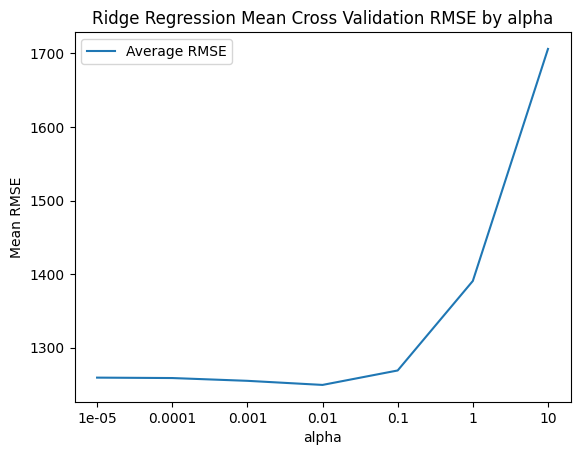

In [17]:
fig, ax = plt.subplots()
ax.plot(avg_rmse_by_alpha, label="Average RMSE")
ax.set_xticks(range(len(alphas)))
ax.set_xticklabels(alphas)
ax.set_xlabel("alpha")
ax.set_ylabel("Mean RMSE")
ax.set_title("Ridge Regression Mean Cross Validation RMSE by alpha")
ax.legend()
fig.savefig("ridge_regression_hyperparameter_tuning.jpeg")
plt.show()

### 2.3.1 Evaluate Best Ridge Regression Model on Train and Test Sets

In [18]:
best_model_index = np.argmin(avg_rmse_by_alpha)
best_ridge_model = ridge_models[best_model_index]
print(best_ridge_model)

Ridge(alpha=0.01)


In [19]:
def get_rmse_ridge_model(model, X, y, scaler):
    """Compute RMSE for the ridge model"""
    ridge_predictions = model.predict(X)
    rmse = np.average(mean_squared_error(y, ridge_predictions, squared=False))
    # The count was MinMaxScaled to use in model training. But for better interpretability of
    # the results, it is transformed back to its original value here
    rmse = daily_label_scaler.inverse_transform(rmse.reshape(-1, 1))
    return rmse

In [20]:
best_model_rmse_train = get_rmse_ridge_model(best_ridge_model, X_train_and_val, y_train_and_val, daily_label_scaler)[0][0]
best_model_rmse_test = get_rmse_ridge_model(best_ridge_model, X_test, y_test, daily_label_scaler)[0][0]
print(best_model_rmse_train)
print(best_model_rmse_test)

BEST_MODEL_PERFORMANCES["ridge"]["train"] = best_model_rmse_train
BEST_MODEL_PERFORMANCES["ridge"]["test"] = best_model_rmse_test

969.0154216038247
1307.4153172253148


In [21]:
BEST_MODEL_PERFORMANCES

{'baseline': {'train': 1035.6402824583395, 'test': 1363.4416200491169},
 'ridge': {'train': 969.0154216038247, 'test': 1307.4153172253148},
 'feedforward': {'train': 0, 'test': 0},
 'lstm': {'train': 0, 'test': 0}}

## 2.4 Feedforward Neural Network

In [22]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

### 2.4.1 Model Architecture

In [23]:
class BikeshareDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()
        self.dataset_size = len(self.y)
    
    def __len__(self):
        return self.dataset_size
        
    def __getitem__(self, idx):
        feature_vec = self.X[idx]
        label = self.y[idx]
        return feature_vec, label
    
    
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(23, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)
    

In [24]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """Train the neural net"""
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_loop(dataloader, model):
    """Evaluate the neural net on a holdout set"""
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    error = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X).numpy()
            error += mean_squared_error(y.numpy(), pred, squared=False)   
    error /= num_batches
    return error

### 2.4.2 Run Cross Validation With Different Hyperparameter Configurations to Find Best Model

In [25]:
n_epochs = 50
configurations = [(nn.MSELoss(), 1e-2),
                  (nn.MSELoss(), 1e-3),
                  (nn.L1Loss(), 1e-2),
                  (nn.L1Loss(), 1e-3)]

mean_validation_rmse_by_configuration = []

# Run cross validation for each hyperparameter configuration.
# For each configuration, train K models over all of the cross validation splits
# and compute the average RMSE. The average RMSE over the cross validation splits
# is that configuration's score.
for loss_fn, learning_rate in configurations:
    print(f"Training with configuration: (loss_fn={loss_fn}, lr={learning_rate})")
    rmse_scores_feedforward_nn = []
    for train_indices, validation_indices in crossval_indices:
        model = NeuralNetwork()  # Create a new model to train
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        train_dataloader = DataLoader(BikeshareDataset(X_train_and_val[train_indices], y_train_and_val[train_indices]), batch_size=64, shuffle=False)
        validation_dataloader = DataLoader(BikeshareDataset(X_train_and_val[validation_indices], y_train_and_val[validation_indices]), batch_size=64, shuffle=False)
        epochs = n_epochs
        for _ in range(epochs):
            train_loop(train_dataloader, model, loss_fn, optimizer)
        rmse_scores_feedforward_nn.append(test_loop(validation_dataloader, model))

    mean_rmse_feedforward_nn = daily_label_scaler.inverse_transform(np.average(rmse_scores_feedforward_nn).reshape(-1, 1))
    mean_validation_rmse_by_configuration.append((mean_rmse_feedforward_nn[0][0], (loss_fn, learning_rate), model))


Training with configuration: (loss_fn=MSELoss(), lr=0.01)
Training with configuration: (loss_fn=MSELoss(), lr=0.001)
Training with configuration: (loss_fn=L1Loss(), lr=0.01)
Training with configuration: (loss_fn=L1Loss(), lr=0.001)


In [26]:
best_rmse, best_config, best_model = min(mean_validation_rmse_by_configuration, key = lambda t: t[0])
print(best_config)

(L1Loss(), 0.01)


### 2.4.3 Evaluate the Best Model on Train and Test Sets

In [27]:
def get_rmse_feedforward_nn_model(model, dataloader, scaler):
    rmse = test_loop(dataloader, model)
    rmse = daily_label_scaler.inverse_transform(rmse.reshape(-1, 1))
    return rmse

In [28]:
train_dataloader = DataLoader(BikeshareDataset(X_train_and_val, y_train_and_val), batch_size=64, shuffle=False)
test_dataloader = DataLoader(BikeshareDataset(X_test, y_test), batch_size=64, shuffle=False)

best_model_rmse_train = get_rmse_feedforward_nn_model(best_model, train_dataloader, daily_label_scaler)[0][0]
best_model_rmse_test = get_rmse_feedforward_nn_model(best_model, test_dataloader, daily_label_scaler)[0][0]
print(best_model_rmse_train)
print(best_model_rmse_test)

BEST_MODEL_PERFORMANCES["feedforward"]["train"] = best_model_rmse_train
BEST_MODEL_PERFORMANCES["feedforward"]["test"] = best_model_rmse_test

1387.8865265667437
1764.8685614764688


In [29]:
BEST_MODEL_PERFORMANCES

{'baseline': {'train': 1035.6402824583395, 'test': 1363.4416200491169},
 'ridge': {'train': 969.0154216038247, 'test': 1307.4153172253148},
 'feedforward': {'train': 1387.8865265667437, 'test': 1764.8685614764688},
 'lstm': {'train': 0, 'test': 0}}

# 3. Long Short Term Memory (LSTM) Model

In [30]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # Suppress tensorflow debugging info
import keras
from keras.utils import timeseries_dataset_from_array
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam, SGD

### 3.1 Data Preparation

In [31]:
data_file = "data/hour.csv"
hourly_df = pd.read_csv(data_file)

In [32]:
def nearest_fill_missing_hours(data):
    """Fill missing hours with the nearest available data"""
    data_copy = data.copy()
    data_copy = (data_copy
                 .set_index("hr")
                 .reindex(list(range(24)), method="nearest")
                 .reset_index())
    return data_copy

In [33]:
# The hourly data has missing values, so fill them with the nearest available data
hourly_df = hourly_df.groupby("dteday").apply(nearest_fill_missing_hours).reset_index(drop=True)
hourly_df.head(5)

,hr,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,0,1,2011-01-01,1,0,1,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,2,2011-01-01,1,0,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2,3,2011-01-01,1,0,1,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,3,4,2011-01-01,1,0,1,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,4,5,2011-01-01,1,0,1,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [34]:
# We'll need the total count on each day, it is the label
count_by_day = hourly_df[["dteday", "cnt"]].groupby("dteday").sum()

# Remove any unneeded columns
hourly_df = hourly_df[feature_columns + [label_column]]
preprocessed_hourly_df, hourly_label_scaler = preprocess_bikeshare_data(hourly_df, categorical_cols=categorical_columns, label_col=label_column)

# Apply the MinMaxScaler to the daily counts
count_by_day["cnt"] = hourly_label_scaler.transform(np.array(count_by_day["cnt"]).reshape(-1, 1))

In [35]:
hourly_df.iloc[0]

season         1.0000
holiday        0.0000
weekday        6.0000
workingday     0.0000
weathersit     1.0000
temp           0.2400
atemp          0.2879
hum            0.8100
windspeed      0.0000
cnt           16.0000
Name: 0, dtype: float64

### 3.2 Split into Training, Validation, and Test Sets

In [36]:
HOURS_PER_DAY = 24
TOTAL_NUM_DAYS = len(hourly_df) / HOURS_PER_DAY

# Input samples will be all except the hourly measurements taken on the last day,
# because we don't have a label for that day (i.e., no data for the day after it)
X_lstm = preprocessed_hourly_df.iloc[:-HOURS_PER_DAY, :].to_numpy()

# Labels will be the sum of each 24 hour period. I.e., total ridership in one day.
# CANNOT use the raw daily data for this, as hourly values have been nearest-filled
y_lstm = np.apply_along_axis(sum, 1, np.array_split(np.array(preprocessed_hourly_df["cnt"][HOURS_PER_DAY:]), TOTAL_NUM_DAYS - 1))

print(f"X shape: {X_lstm.shape}")
print(f"y shape: {y_lstm.shape}")

X shape: (17520, 24)
y shape: (730,)


In [37]:
# The test set will be the last 100 days of data
lstm_test_set_size = HOURS_PER_DAY * 100
lstm_train_set_size = len(X_lstm) - lstm_test_set_size

X_train_and_val_lstm = X_lstm[:lstm_train_set_size]
y_train_and_val_lstm = y_lstm[:(lstm_train_set_size // HOURS_PER_DAY)]
X_test_lstm = X_lstm[lstm_train_set_size:]
y_test_lstm = y_lstm[(lstm_train_set_size // HOURS_PER_DAY):]

In [38]:
crossval_indices = create_timeseries_crossval_splits(X_train_and_val_lstm, n_splits=5)

In [39]:
BATCH_SIZE=64

lstm_datasets = []
for train_indices, validation_indices in crossval_indices:
    X_train = X_train_and_val_lstm[train_indices]
    y_train = y_train_and_val_lstm[train_indices // HOURS_PER_DAY]
    X_val = X_train_and_val_lstm[validation_indices]
    y_val = y_train_and_val_lstm[validation_indices // HOURS_PER_DAY]
    
    train_dataset = timeseries_dataset_from_array(
        data=X_train,
        targets=y_train,
        sequence_length=HOURS_PER_DAY,
        batch_size=BATCH_SIZE)

    validation_dataset = timeseries_dataset_from_array(
        data=X_val,
        targets=y_val,
        sequence_length=HOURS_PER_DAY,
        batch_size=BATCH_SIZE)

    lstm_datasets.append((train_dataset, validation_dataset))
    
print(f"There are {len(lstm_datasets)} splits for LSTM timeseries cross validation")

Metal device set to: Apple M1 Pro
There are 5 splits for LSTM timeseries cross validation


In [40]:
def build_lstm_model(input_shape, nodes_per_layer, lr):
    """Helper to enable trying different hyperparameters to find best configuration
    
    Args:
        input_shape (tuple): Shape of the input tensors
        nodes_per_layer (int): Number of nodes in each of the 2 hidden layers
        lr (float): Learning rate
    
    Returns:
        Sequential: A Keras Sequential LSTM model
    """
    model = Sequential()
    model.add(keras.Input(shape=input_shape))  # `None` indicates the sequence is of arbitrary length
    model.add(LSTM(nodes_per_layer, return_sequences=True))
    model.add(Dropout(0.15))
    model.add(LSTM(nodes_per_layer))
    model.add(Dropout(0.15))
    model.add(Dense(1))
    model.compile(optimizer=SGD(learning_rate=lr),
                  loss="mean_squared_error", 
                  metrics=["mse"])
    model.build()
    return model

In [41]:
LSTM_CONFIGURATIONS = [(16, 1e-3),
                       (16, 1e-4),
                       (32, 1e-3),
                       (32, 1e-4)]

FEATURE_VEC_SIZE = 24
model = build_lstm_model(input_shape=(HOURS_PER_DAY, FEATURE_VEC_SIZE), nodes_per_layer=16, lr=1e-2)

In [42]:
%%time
configs_histories_rmse_models = []
for nodes_per_layer, learning_rate in LSTM_CONFIGURATIONS:
    print(f"Running cross validation with configuration: nodes={nodes_per_layer}, lr={learning_rate}")
    histories = []
    for i, (train_dataset, validation_dataset) in enumerate(lstm_datasets):
        history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset, verbose=0)
        histories.append(history.history)
    root_rmses = np.sqrt([hist["val_mse"] for hist in histories])
    avg_rmse = np.average(root_rmses)
    configs_histories_rmse_models.append(((nodes_per_layer, learning_rate), histories[-1], avg_rmse, model))

Running cross validation with configuration: nodes=16, lr=0.001
Running cross validation with configuration: nodes=16, lr=0.0001
Running cross validation with configuration: nodes=32, lr=0.001
Running cross validation with configuration: nodes=32, lr=0.0001
CPU times: user 8min 57s, sys: 4min 29s, total: 13min 27s
Wall time: 5min 57s


In [43]:
best_config, best_history, best_rmse, best_lstm_model = min(configs_histories_rmse_models, key = lambda t: t[2])

In [44]:
print(best_config)

(32, 0.001)


### 3.3 Evaluate the Best LSTM Model Configuration

In [45]:
eval_train_dataset = timeseries_dataset_from_array(
    data=X_train_and_val_lstm[train_indices],
    targets=y_train_and_val_lstm[train_indices // HOURS_PER_DAY],
    sequence_length=HOURS_PER_DAY,
    batch_size=BATCH_SIZE)

eval_test_dataset = timeseries_dataset_from_array(
    data=X_test_lstm,
    targets=y_test_lstm,
    sequence_length=HOURS_PER_DAY,
    batch_size=BATCH_SIZE)

In [46]:
def evaluate_lstm_model(dataset, model, scaler):
    batch_errors = []
    for X, y in dataset:
        predictions = model(X).numpy()
        rmse = np.average(mean_squared_error(y.numpy(), predictions, squared=False))
        rmse = scaler.inverse_transform(rmse.reshape(-1, 1))
        batch_errors.append(rmse)
    return np.average(batch_errors)

In [47]:
best_lstm_model_rmse_train = evaluate_lstm_model(eval_train_dataset, best_lstm_model, hourly_label_scaler)
best_lstm_model_rmse_test = evaluate_lstm_model(eval_test_dataset, best_lstm_model, hourly_label_scaler)

print(best_lstm_model_rmse_train)
print(best_lstm_model_rmse_test)

BEST_MODEL_PERFORMANCES["lstm"]["train"] = best_lstm_model_rmse_train
BEST_MODEL_PERFORMANCES["lstm"]["test"] = best_lstm_model_rmse_test

1879.1334771233016
2090.9435168808855


In [48]:
BEST_MODEL_PERFORMANCES

{'baseline': {'train': 1035.6402824583395, 'test': 1363.4416200491169},
 'ridge': {'train': 969.0154216038247, 'test': 1307.4153172253148},
 'feedforward': {'train': 1387.8865265667437, 'test': 1764.8685614764688},
 'lstm': {'train': 1879.1334771233016, 'test': 2090.9435168808855}}

# 4. Compare Performance of Best Models

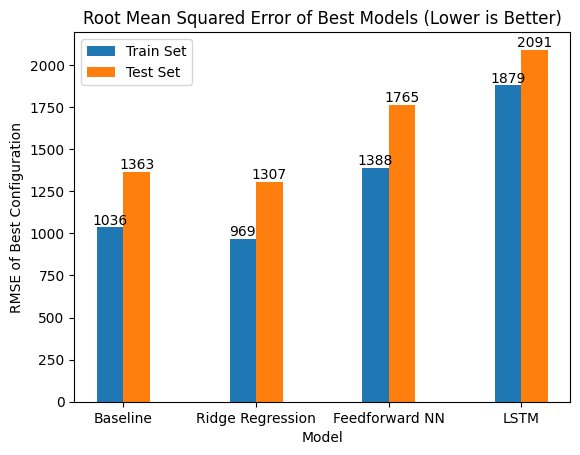

In [49]:
model_names = ["baseline", "ridge", "feedforward", "lstm"]
all_train_rmses = [np.around(BEST_MODEL_PERFORMANCES[model_type]["train"]) for model_type in model_names]
all_test_rmses = [np.around(BEST_MODEL_PERFORMANCES[model_type]["test"]) for model_type in model_names]

fig, ax = plt.subplots()

train_bars = ax.bar([0.9, 1.9, 2.9, 3.9], all_train_rmses, width=0.2, label="Train Set")
ax.bar_label(train_bars)
test_bars = ax.bar([1.1, 2.1, 3.1, 4.1], all_test_rmses, width=0.2, label="Test Set")
ax.bar_label(test_bars)
ax.set_title("Root Mean Squared Error of Best Models (Lower is Better)")
ax.set_xlabel("Model")
ax.set_ylabel("RMSE of Best Configuration")
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(["Baseline", "Ridge Regression", "Feedforward NN", "LSTM"])
ax.legend()
fig.savefig("best_model_performances.jpeg")
plt.show()


# Discussion

Perhaps counterintuitively, the more sophisticated neural network models performed significantly worse than the simple ridge regression model. Even the naive baseline "model" outperformed them.

The simplest explanation in this case is that the training set was too small for the neural networks to generalize well. However, even with a larger dataset there simply may not be a strong temporal relationship in the data. Having samples from previous hours and days may help capture cyclical or seasonal influences, such as the general trend of higher ridership in warmer months and lower ridership in colder months, but it is likely not helpful with respect to other features. Take the weather, for example. Does the fact it was raining yesterday have a strong influence on ridership today? I doubt it, even if the ground is still a little wet. Similarly, if it is raining today it does not matter that the weather was clear yesterday.
